# Lab | Imbalanced data

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


from imblearn.over_sampling import SMOTE

 ### 1. Load the dataset and explore the variables.

In [2]:
df = pd.read_csv("/Users/ignaciolorenzoqueralt/Documents/Ironhack/labs/lab-imbalanced-data/files_for_lab/customer_churn.csv")
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


### 2. We will try to predict variable `Churn` using a logistic regression on variables `tenure`, `SeniorCitizen`,`MonthlyCharges`.

In [3]:
df = df.filter(['tenure','SeniorCitizen','MonthlyCharges', 'Churn'], axis=1)

In [4]:
def standardize_headers(df):
    df.columns = df.columns.str.lower().str.replace(' ', '_')
standardize_headers(df)

In [5]:
df.head(3)

,tenure,seniorcitizen,monthlycharges,churn
0,1,0,29.85,No
1,34,0,56.95,No
2,2,0,53.85,Yes


We can see that 'seniorcitizen' only has values 1 and 0, so we should treat this feature as a categorical colummn.

In [6]:
df.seniorcitizen = df.seniorcitizen.astype(object)

### 3. Extract the target variable.

In [7]:
y = df['churn']
y.head(3)

0     No
1     No
2    Yes
Name: churn, dtype: object

### 4. Extract the independent variables and scale them.

In [8]:
X = df.drop('churn', axis=1)
X.head(3)

,tenure,seniorcitizen,monthlycharges
0,1,0,29.85
1,34,0,56.95
2,2,0,53.85


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


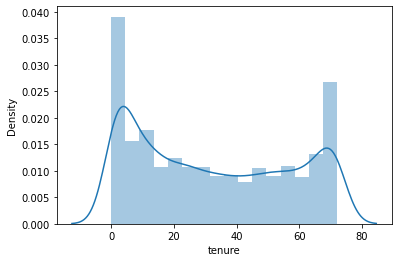

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


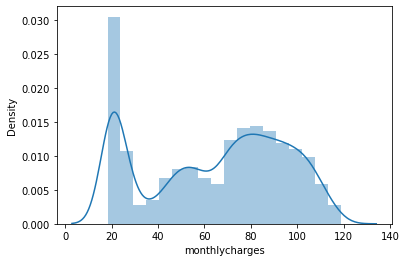

In [9]:
for column in df.select_dtypes(np.number).columns:
    sns.distplot(df[column])
    plt.show()

In [10]:
def boxcox_transform(df):
    numeric_cols = df.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        df[column] = np.where(df[column]<=0, np.NAN, df[column]) 
        df[column] = df[column].fillna(df[column].mean())
        transformed_data, ci = stats.boxcox(df[column])
        df[column] = transformed_data
        _ci[column] = [ci] 
    return df, _ci

X_normalized, _ci = boxcox_transform(X)
X_normalized.shape, y.shape

((7043, 3), (7043,))

In [11]:
'''
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
df = pd.DataFrame(x_scaled)
'''

'\nmin_max_scaler = preprocessing.MinMaxScaler()\nx_scaled = min_max_scaler.fit_transform(X)\ndf = pd.DataFrame(x_scaled)\n'

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


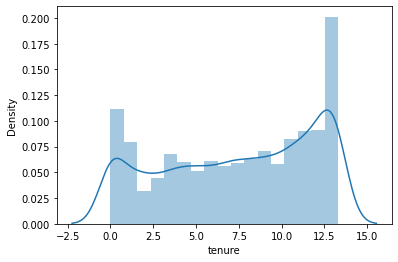

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


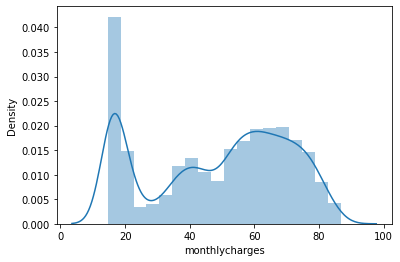

In [12]:
for column in X.select_dtypes(np.number).columns:
    sns.distplot(X[column])
    plt.show()

### 5. Build the logistic regression model.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classification = LogisticRegression(random_state=42, max_iter=1000)

classification.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### 6. Evaluate the model.

In [15]:
classification.score(X_test, y_test)

0.801277501774308

In [19]:
predictions = classification.predict(X_test)
predictions

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [22]:
confusion_matrix(y_test, predictions)

array([[956,  80],
       [200, 173]])

<AxesSubplot:>

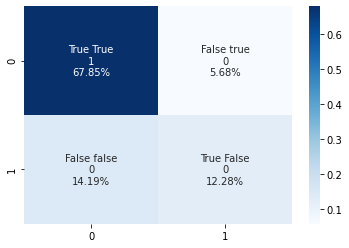

In [24]:
cf_matrix = confusion_matrix(y_test, predictions, normalize='all')

group_names = ['True True', 'False true', 'False false', 'True False']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### 7. Even a simple model will give us more than 70% accuracy. Why?

In [29]:
df['churn'].value_counts(normalize=True) * 100

No     73.463013
Yes    26.536987
Name: churn, dtype: float64

If we create a rule based model that only returns 'No' as a prediction, we will have a 73% accuracy.

### 8. Synthetic Minority Oversampling TEchnique (SMOTE) is an over sampling technique based on nearest neighbors that adds new points between existing points. Apply `imblearn.over_sampling.SMOTE` to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?

- We have a less biased model which predicts better "True False"

In [31]:
smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

No     5174
Yes    5174
Name: churn, dtype: int64

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

classification = LogisticRegression(random_state=42, max_iter=1000)

classification.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [33]:
classification.score(X_test, y_test)

0.7478260869565218

In [34]:
predictions = classification.predict(X_test)
predictions

array(['Yes', 'No', 'No', ..., 'Yes', 'Yes', 'Yes'], dtype=object)

In [35]:
confusion_matrix(y_test, predictions)

array([[754, 267],
       [255, 794]])

<AxesSubplot:>

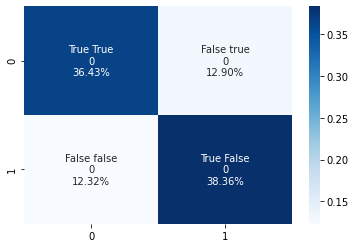

In [36]:
cf_matrix = confusion_matrix(y_test, predictions, normalize='all')

group_names = ['True True', 'False true', 'False false', 'True False']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### 9. Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process. Apply `imblearn.under_sampling.TomekLinks` to the dataset. Build and evaluate the logistic regression model. Is it there any improvement?